In [2]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia
import os

In [3]:
# Print columns of hdul[1] file
file_path = "../data/psf_y3a1-v29.fits"
hdul = fits.open(file_path)
print(hdul[1].columns)


ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'x'; format = 'D'
    name = 'y'; format = 'D'
    name = 'obs_e1'; format = 'D'
    name = 'obs_e2'; format = 'D'
    name = 'obs_T'; format = 'D'
    name = 'piff_e1'; format = 'D'
    name = 'piff_e2'; format = 'D'
    name = 'piff_T'; format = 'D'
    name = 'mag'; format = 'D'
    name = 'fov_x'; format = 'D'
    name = 'fov_y'; format = 'D'
    name = 'exp'; format = 'J'
    name = 'ccd'; format = 'I'
    name = 'band'; format = '1A'
    name = 'tiling'; format = 'I'
)


In [4]:
def read_des_fits(file_path):
    # Read in the fits file and close it
    hdul = fits.open(file_path)
    
    # hdul[1].data is a numpy recarray. Get the ra, dec, mag and band columns   
    cols = ['ra', 'dec', 'mag', 'band']
    zidx = np.random.choice(np.where(hdul[1].data['band'] == 'z')[0], size = 1000, replace = False)
    data = {col: hdul[1].data[col][zidx] for col in cols}
    hdul.close()

    des = pd.DataFrame(data)
    

    # Combine ra and dec into a sky coord array
    des['coord'] = SkyCoord(ra=des['ra'], dec=des['dec'], unit = 'deg')
    return des

# Read in the DES data
file_path = "../data/psf_y3a1-v29.fits"
des = read_des_fits(file_path)


In [5]:
# Print max and min of magnitude column
des['mag'].max(), des['mag'].min()

(20.999704360961914, 15.62669563293457)

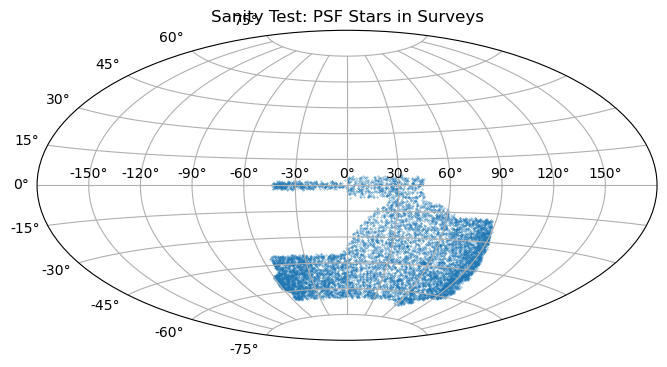

In [4]:
# Function to plot the ra and dec of the PSF stars
def plot_sanity_test(coord, n = 10000):
    plt.figure(figsize=(8,4.2))
    plt.subplot(111, projection="aitoff")
    plt.title("Sanity Test: PSF Stars in Surveys")
    plt.grid(True)
    
    # Choose n random stars
    coord = coord.sample(n=n)
    
    ra_rad = np.array([c.ra.wrap_at(180 * u.deg).radian for c in coord])
    dec_rad = np.array([c.dec.radian for c in coord])
    plt.scatter(ra_rad, dec_rad, s=0.1, alpha=0.8)
    plt.show()
    
# Plot the ra and dec of the PSF stars
plot_sanity_test(des['coord'])


In [24]:
# Get 2D array of ra and dec from dataframe
ra_dec = np.array([des['ra'], des['dec']]).T
ridx = np.random.choice(np.arange(ra_dec.shape[0]), size = 10000, replace = False)
ra_dec_sample = ra_dec[ridx]
print(ra_dec_sample.shape)
# Perform clustering
number_of_clusters = 200
cents = kmeans(ra_dec_sample, number_of_clusters)
print("Centroids found.")
centroids = cents[0]
cluster_num_array = vq(ra_dec, centroids)

# Generate cluster info df
max_dist_pts = {i:[np.array([k for k in cluster_num_array[1][cluster_num_array[0] == i]]).max()] for i in range(number_of_clusters)}
cluster_info = pd.DataFrame(max_dist_pts).T
cluster_info.columns = ["max_dist"]
cluster_info["clusterno"] = cluster_info.index
cluster_info["dists"] = [cluster_num_array[1][cluster_num_array[0] == i] for i in cluster_info["clusterno"]]
cluster_info["centroids"] = list(centroids)

(10000, 2)
Centroids found.


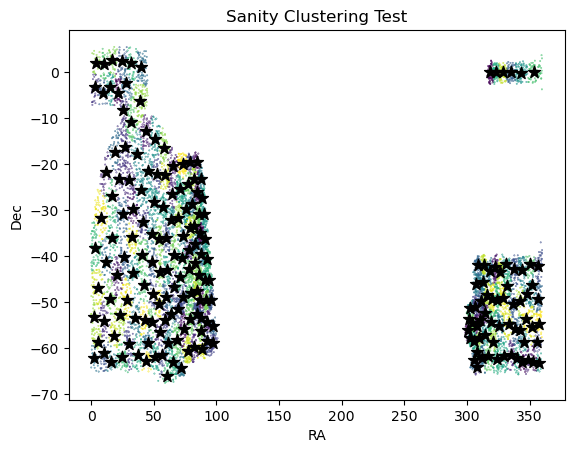

In [25]:
# Sanity check: plot clustering result
def plot_cluster_test(ra_dec, centroids, cluster_num_array):
    
    # Sample 10000 random 2D points from numpy array
    idx = np.random.choice(ra_dec.shape[0], 10000, replace=False)
    rds = ra_dec[idx, :]
    
    # scatter plot of K-Means cluster
    plt.scatter(rds[:, 0],
                rds[:, 1],
                c=cluster_num_array[0][idx], s  = 0.1)
    
    # Centroid of the clusters
    plt.scatter(centroids[:, 0],
                centroids[:, 1],
                marker='*',
                s=80,
                color='black')

    plt.title("Sanity Clustering Test")
    plt.xlabel("RA")
    plt.ylabel("Dec")
    
# plot cluster test
plot_cluster_test(ra_dec, cents[0], cluster_num_array)

In [26]:
def query_gaia_for_cluster_old(ra, dec, dist):
    # Define the center coordinates of your region and the search radius
    center_coordinates = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
    search_radius = dist * u.deg  # Adjust the radius as needed
    
    Gaia.ROW_LIMIT = -1
    job = Gaia.cone_search_async(center_coordinates, radius=search_radius, columns=["ra", "dec"])
    result_table = job.get_results()
    gaia_table = result_table.to_pandas()
    
    return gaia_table

In [27]:
def query_gaia_for_cluster(ra, dec, dist, lim = 1e6):
    # Define the center coordinates of your region and the search radius
    center_coordinates = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
    search_radius = dist * u.deg  # Adjust the radius as needed
    
    # Q = """
    # select
    # source_id, ra, dec, 
    # phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star,
    # astrometric_excess_noise,
    # LOG10(astrometric_excess_noise) < GREATEST((phot_g_mean_mag - 18.2) * 0.3 + 0.2, 0.3) as is_star
    # from gaiadr3.gaia_source
    # WHERE 1 = CONTAINS(
    # POINT({ra}, {dec}),
    # CIRCLE(ra, dec, {radius}))
    # order by source_id
    # """
    # and in_qso_candidates = 'False'
    # and in_galaxy_candidates = 'False'
    # and non_single_star = 0
    
    Q = """
    select top {limit} ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT({ra}, {dec}),
    CIRCLE(ra, dec, {radius}))
    order by source_id
    """

    Gaia.ROW_LIMIT = -1
    # job = Gaia.cone_search_async(center_coordinates, radius=search_radius, columns=["ra", "dec"])
    # result_table = job.get_results()
    query = Q.format(ra=ra,dec=dec,radius=search_radius.value, limit = int(lim))
    print(query)
    job = Gaia.launch_job(query, dump_to_file=True)
    result_table = job.get_results()
    gaia_table = result_table.to_pandas()
    
    gaia_table["is_star"] = (np.log10(gaia_table['astrometric_excess_noise']) < np.maximum((gaia_table['phot_g_mean_mag']-18.2)*.3+.2,.3))
    gaia_table.drop(columns=['astrometric_excess_noise', 'phot_g_mean_mag'], inplace=True)
    
    if len(gaia_table) == lim:
        print("Warning: Limit reached. Increase limit or decrease radius.")
    
    return gaia_table

In [28]:
def match_cluster_to_gaia(cluster_num_array, ra_dec, cluster_info, cluster_num):
    """
    Match stars in cluster 'cluster_num' to gaia stars. Create a table with gaia coords, cluster coords, and flag for matched stars.
    """
    
    # Query gaia and match stars to cluster
    clust0_info = cluster_info.loc[cluster_num]
    gaia0_tab = query_gaia_for_cluster(clust0_info["centroids"][0], clust0_info["centroids"][1], clust0_info["max_dist"])
    cluster0 = SkyCoord(ra_dec[cluster_num_array[0] == cluster_num] * u.deg)
    mag0 = np.array(des['mag'][cluster_num_array[0] == cluster_num])
    gaia0 = SkyCoord(ra = gaia0_tab['ra'], dec = gaia0_tab['dec'], unit=u.deg)
    idx_clust, sep2d_clust, _ = cluster0.match_to_catalog_sky(gaia0)
    
    # Create table with gaia0 coords, cluster0 coords, and flag for matched stars
    comb_stars = pd.DataFrame({'matched': np.zeros(len(cluster0))})
    comb_stars.loc[sep2d_clust < 1 * u.arcsec] = 1
    comb_stars['sep2d'] = sep2d_clust.arcsec # in arcsec
    comb_stars['mag0'] = mag0
    comb_stars['is_star'] = np.array(gaia0_tab['is_star'].iloc[idx_clust])
    comb_stars['in_qso_candidates'] = np.array(gaia0_tab['in_qso_candidates'].iloc[idx_clust])
    comb_stars['in_galaxy_candidates'] = np.array(gaia0_tab['in_galaxy_candidates'].iloc[idx_clust])
    comb_stars['non_single_star'] = np.array(gaia0_tab['non_single_star'].iloc[idx_clust])

    get_ra = lambda x: x.ra.degree
    get_dec = lambda x: x.dec.degree

    comb_stars["gaia_ra"] = gaia0[idx_clust].ra.degree
    comb_stars["gaia_dec"] = gaia0[idx_clust].dec.degree
    comb_stars["cluster_ra"] = cluster0.ra.degree
    comb_stars["cluster_dec"] = cluster0.dec.degree
    
    return comb_stars

comb_cluster0, gtab, idxc = match_cluster_to_gaia(cluster_num_array, ra_dec, cluster_info, 0)

In [29]:
# Combine pandas dataframes from all clusters
master_comb_df = pd.DataFrame()
for i in range(1, number_of_clusters): # NOTE: STARTING FROM 1.
    print("Matching cluster " + str(i) + " to Gaia...")
    comb_clusteri = match_cluster_to_gaia(cluster_num_array, ra_dec, cluster_info, i)
    comb_clusteri.to_csv(f"../../int_data/DESY3_Cluster_{i}.csv")
    master_comb_df = pd.concat([master_comb_df, comb_clusteri])

Matching cluster 1 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(344.2295650681098, -62.947594238807305),
    CIRCLE(ra, dec, 3.5958182959250142))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 2 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(318.6583389513828, -0.038213007295299396),
    CIRCLE(ra, dec, 3.2969493263759073))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 3 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(21.49717981499207, -4.609744757283655),
    CIRCLE(ra, dec, 4.730006120554065))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 4 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(300.46413987103165, -55.95430289861406),
    CIRCLE(ra, dec, 3.1287631546001102))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 5 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(87.2205755249161, -49.562286388663004),
    CIRCLE(ra, dec, 3.1724362649553277))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 6 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(84.56351968551542, -26.083970121824002),
    CIRCLE(ra, dec, 2.8609680884546895))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 7 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(73.75563520568893, -55.856284770796336),
    CIRCLE(ra, dec, 4.412975791241833))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 8 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(84.64706706646054, -19.588352973528604),
    CIRCLE(ra, dec, 3.3528428651091056))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 9 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(353.11404256865404, -62.88510055684178),
    CIRCLE(ra, dec, 3.9054586073485846))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 10 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(307.6190310173829, -55.058681491820835),
    CIRCLE(ra, dec, 2.3881141816277642))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 11 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(33.264957007638166, -29.841345033041126),
    CIRCLE(ra, dec, 4.823969962327039))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 12 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(322.35250498385824, -42.314887857545784),
    CIRCLE(ra, dec, 3.7394932835750883))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 13 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(310.4581691868921, -53.76227143989673),
    CIRCLE(ra, dec, 2.8300910097816616))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 14 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(20.71096758972667, -44.038722782077045),
    CIRCLE(ra, dec, 5.078678433059254))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 15 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(92.75826129951608, -54.28863777939007),
    CIRCLE(ra, dec, 3.0008934501336286))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 16 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(43.87990700722995, -12.769600717847513),
    CIRCLE(ra, dec, 6.133177686573932))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 17 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(314.48791773500335, -52.38301005878628),
    CIRCLE(ra, dec, 3.242574121193746))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 18 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(65.06457226874748, -20.43444919577111),
    CIRCLE(ra, dec, 5.194466945301499))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 19 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(348.7976015856639, -62.54348463414274),
    CIRCLE(ra, dec, 3.9396267685963453))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 20 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(64.53893147271468, -26.510719144660722),
    CIRCLE(ra, dec, 4.058057678040619))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 21 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(335.2896509675032, -61.368199083452396),
    CIRCLE(ra, dec, 5.123135154536108))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 22 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(82.12128716718408, -59.808783927367784),
    CIRCLE(ra, dec, 4.000021917966454))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 23 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(12.017860574907768, -21.792625487045658),
    CIRCLE(ra, dec, 7.389820113000551))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 24 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(30.206867592656735, -23.351925266041498),
    CIRCLE(ra, dec, 5.193758042319325))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 25 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(54.612124924889805, -56.524840865327164),
    CIRCLE(ra, dec, 4.063217137077141))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 26 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(10.32499597858638, -54.000344098923314),
    CIRCLE(ra, dec, 4.8127280802872585))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 27 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(77.94763930698831, -38.572655579313135),
    CIRCLE(ra, dec, 3.1816452396521813))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 28 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(308.0897337124044, -64.02449209898012),
    CIRCLE(ra, dec, 3.2784014369766017))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 29 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(25.54783772434718, -8.237060432848194),
    CIRCLE(ra, dec, 5.800934129472395))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 30 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(22.218201105111653, -23.172032300646592),
    CIRCLE(ra, dec, 4.959475584980655))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 31 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(27.09643673878625, -16.165151167145055),
    CIRCLE(ra, dec, 5.618697880764333))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 32 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(3.4282723047536843, -3.1221220937380014),
    CIRCLE(ra, dec, 5.504067718474157))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 33 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(66.0629427923469, -46.59376205867292),
    CIRCLE(ra, dec, 3.8612079110720745))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 34 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(59.01464433035707, -53.903657434428034),
    CIRCLE(ra, dec, 3.584973287561899))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 35 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(41.26476928087403, -32.62472844431087),
    CIRCLE(ra, dec, 5.410073257381937))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 36 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(78.98924794433452, -19.46122711114159),
    CIRCLE(ra, dec, 3.6637631492111984))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 37 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(306.6281394704231, -50.96389981133887),
    CIRCLE(ra, dec, 2.9235244708045287))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 38 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(30.441746352378523, -59.11153604387754),
    CIRCLE(ra, dec, 6.3893008709906685))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 39 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(97.17557215359534, -58.81367484296003),
    CIRCLE(ra, dec, 3.843103987522394))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 40 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(52.37380815381326, -22.174321578212034),
    CIRCLE(ra, dec, 4.544463387681772))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 41 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(49.47639068973501, -48.19931214502092),
    CIRCLE(ra, dec, 4.526388837995695))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 42 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(56.853209054859484, -61.50263687724928),
    CIRCLE(ra, dec, 5.956335638493228))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 43 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(356.22769724245063, -58.59434642606488),
    CIRCLE(ra, dec, 3.8884421807101623))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 44 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(72.9422083654098, -48.83375434477085),
    CIRCLE(ra, dec, 3.96410757437535))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 45 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(92.6860216949912, -58.36621689776729),
    CIRCLE(ra, dec, 3.8202433592193894))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 46 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(356.8563979541135, -42.04634452233075),
    CIRCLE(ra, dec, 9.045758118105715))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 47 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(84.68264650554843, -52.48673348480055),
    CIRCLE(ra, dec, 4.003479758777117))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 48 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(69.07082198795636, -51.36887539479509),
    CIRCLE(ra, dec, 3.865100343301128))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 49 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(60.01142383740465, -36.06995643848557),
    CIRCLE(ra, dec, 4.376199113509256))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 50 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(337.70046883362426, -42.78111872707528),
    CIRCLE(ra, dec, 4.6112676472505445))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 51 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(87.9695222567275, -53.332383916127554),
    CIRCLE(ra, dec, 2.8841642496789706))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 52 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(10.354719272032426, -61.02249261174819),
    CIRCLE(ra, dec, 5.502536677763102))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 53 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(95.55085421060916, -49.49263881435688),
    CIRCLE(ra, dec, 3.1079838290985538))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 54 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(24.639812926031205, 2.371443794998239),
    CIRCLE(ra, dec, 4.91004289403054))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 55 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(311.1383263202425, -49.63499396054259),
    CIRCLE(ra, dec, 2.914085552439974))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 56 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(336.9828176446371, -50.37543952415174),
    CIRCLE(ra, dec, 4.227364823540945))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 57 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(9.287184073035638, -4.447221926484499),
    CIRCLE(ra, dec, 4.636666477305568))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 58 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(48.762044156741275, -41.29464953548428),
    CIRCLE(ra, dec, 4.450721468897776))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 59 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(26.186680328890322, -40.182524662331026),
    CIRCLE(ra, dec, 5.612301409140803))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 60 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(334.94380891095403, 0.06449453414373457),
    CIRCLE(ra, dec, 4.721655480086025))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 61 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(338.35988406637154, -55.923220005309716),
    CIRCLE(ra, dec, 3.681322079844207))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 62 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(59.71742226308439, -48.91884897707704),
    CIRCLE(ra, dec, 3.8853723446644834))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 63 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(25.205826464272608, -30.800593646096754),
    CIRCLE(ra, dec, 5.628435140579185))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 64 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(308.78087132719764, -41.95451096752305),
    CIRCLE(ra, dec, 3.9700575990982947))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 65 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(97.55021417761002, -55.09933048725602),
    CIRCLE(ra, dec, 3.6820828513232757))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 66 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(356.88532529181737, -49.34140339757801),
    CIRCLE(ra, dec, 4.718036017251744))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 67 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(305.2460943581924, -62.55701261702894),
    CIRCLE(ra, dec, 3.424045348030412))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 68 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(18.988299150107416, -17.34688142684411),
    CIRCLE(ra, dec, 5.799187794607879))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 69 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(27.83908671456905, -2.364807668201916),
    CIRCLE(ra, dec, 6.081068737063775))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 70 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(311.88304827702086, -62.09723217478706),
    CIRCLE(ra, dec, 4.127019701245977))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 71 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(11.799119612604548, -41.17005955083522),
    CIRCLE(ra, dec, 5.491541823222207))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 72 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(40.08432448507757, 1.1854160356111274),
    CIRCLE(ra, dec, 6.816639999923318))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 73 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(45.15226180159326, -58.79598623572766),
    CIRCLE(ra, dec, 4.69990117947764))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 74 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(80.81812611609948, -28.637008148927777),
    CIRCLE(ra, dec, 3.1408015910148115))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 75 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(87.89779042575913, -39.47450031585211),
    CIRCLE(ra, dec, 3.280555207349847))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 76 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(1.9461862463470774, -62.1177653539397),
    CIRCLE(ra, dec, 5.506375002264785))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 77 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(342.5362549024324, -56.030033525165905),
    CIRCLE(ra, dec, 3.6584245732500698))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 78 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(73.4085305595882, -35.711235981634175),
    CIRCLE(ra, dec, 4.383170322243323))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 79 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(71.40495837675032, -64.36087389474277),
    CIRCLE(ra, dec, 4.409501261644172))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 80 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(318.40952058917105, -43.11344812507864),
    CIRCLE(ra, dec, 3.5828255299694467))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 81 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(83.16429750113872, -37.3347478828412),
    CIRCLE(ra, dec, 3.060048108635214))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 82 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(35.251574161445646, -53.38147379143499),
    CIRCLE(ra, dec, 5.727968817623529))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 83 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(307.15197271833944, -45.966536890394224),
    CIRCLE(ra, dec, 3.7050851193849192))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 84 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(325.6478566731122, -55.16836922907415),
    CIRCLE(ra, dec, 4.3284306019863985))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 85 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(87.66755897629209, -23.16588328887923),
    CIRCLE(ra, dec, 3.2648184822968496))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 86 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(312.56935392549275, -45.69981438341211),
    CIRCLE(ra, dec, 3.2906247223698437))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 87 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(15.77067350551394, -62.89526463226421),
    CIRCLE(ra, dec, 5.2775596822745365))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 88 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(344.1554744591585, -43.00643520744835),
    CIRCLE(ra, dec, 4.61431609493765))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 89 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(48.29350539025673, -35.242889068679),
    CIRCLE(ra, dec, 4.9337839746197325))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 90 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(36.876044624182626, -17.71383166513455),
    CIRCLE(ra, dec, 5.846586646541207))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 91 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(63.72539526539159, -52.507711819255896),
    CIRCLE(ra, dec, 3.9338734315743142))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 92 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(61.61855313043284, -58.77213255624325),
    CIRCLE(ra, dec, 3.939307613693035))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 93 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(347.8872966974373, -48.15697149641025),
    CIRCLE(ra, dec, 4.568356182772666))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 94 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(39.83214676894066, -25.52715763790996),
    CIRCLE(ra, dec, 5.465770492754274))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 95 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(45.466843028126696, -21.383034857096348),
    CIRCLE(ra, dec, 5.278970565717524))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 96 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(63.59152948827029, -32.073626812289255),
    CIRCLE(ra, dec, 4.363334341016554))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 97 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(314.4797230768228, -57.164337762655045),
    CIRCLE(ra, dec, 3.2543519857987993))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 98 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(351.9164013809737, -46.33810602615668),
    CIRCLE(ra, dec, 4.546043231910605))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 99 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(302.50067954589355, -51.289390769747335),
    CIRCLE(ra, dec, 3.198815976009916))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 100 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(33.16157951628043, -43.62640729205092),
    CIRCLE(ra, dec, 5.664492140897648))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 101 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(50.84970467861934, -14.51862681281956),
    CIRCLE(ra, dec, 5.968224050047419))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 102 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(345.9260720931055, -58.73475174128034),
    CIRCLE(ra, dec, 3.8066921578724))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 103 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(342.9941471080093, -0.14789521371792202),
    CIRCLE(ra, dec, 5.806917425075774))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 104 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(50.22342044497769, -28.227980154505275),
    CIRCLE(ra, dec, 5.4940905074359465))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 105 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(330.93971968763555, -41.65453811952279),
    CIRCLE(ra, dec, 4.0094223930218105))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 106 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(90.10032459387122, -30.85525637076634),
    CIRCLE(ra, dec, 3.456226034261763))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 107 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(90.9621095945958, -36.247711641434016),
    CIRCLE(ra, dec, 3.5353984613307325))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 108 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(75.60168071194805, -29.691463709950185),
    CIRCLE(ra, dec, 3.649300376000632))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 109 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(357.5884700384088, -63.13366320955536),
    CIRCLE(ra, dec, 3.8437464961684906))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 110 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(15.217677677258884, -3.2505814539550326),
    CIRCLE(ra, dec, 4.801797394116541))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 111 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(57.69033361115232, -29.22778522657634),
    CIRCLE(ra, dec, 4.663858448529504))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 112 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(60.47486421423066, -42.97168092920098),
    CIRCLE(ra, dec, 4.3792012521580626))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 113 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(88.70496534853847, -27.239022130906402),
    CIRCLE(ra, dec, 3.2372688134079657))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 114 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(305.2682212256173, -58.3219932212023),
    CIRCLE(ra, dec, 2.3639717981962267))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 115 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(51.02006637616092, -61.9121480840494),
    CIRCLE(ra, dec, 6.207596415537729))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 116 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(329.3218890716339, -61.620826907188814),
    CIRCLE(ra, dec, 4.953195934767677))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 117 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(340.1238369481524, -62.16284444583414),
    CIRCLE(ra, dec, 4.093681747832854))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 118 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(71.21540797355524, -25.432395498573744),
    CIRCLE(ra, dec, 4.253252682382598))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 119 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(302.20361794404374, -57.761223116558575),
    CIRCLE(ra, dec, 3.028902576955018))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 120 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(72.24844275506302, -40.41807370687169),
    CIRCLE(ra, dec, 4.025893663905656))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 121 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(37.29796942513993, -61.465487171069555),
    CIRCLE(ra, dec, 6.198064139457465))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 122 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(90.98385937382123, -45.12956679398369),
    CIRCLE(ra, dec, 3.2632799685586753))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 123 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(323.7085972596109, -62.41160483056197),
    CIRCLE(ra, dec, 4.66184785731792))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 124 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(322.95949185055173, 0.08560287305698841),
    CIRCLE(ra, dec, 3.6787961083888945))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 125 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(65.15963279750011, -63.02395836239067),
    CIRCLE(ra, dec, 4.558699368924975))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 126 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(70.84937370472039, -44.44232056459616),
    CIRCLE(ra, dec, 3.920170271245336))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 127 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(94.37725111997246, -45.11011825474555),
    CIRCLE(ra, dec, 3.332511964335095))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 128 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(16.99250405225777, -36.0277885965599),
    CIRCLE(ra, dec, 5.539540747376503))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 129 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(332.2557658937165, -46.523118614748356),
    CIRCLE(ra, dec, 4.157091986726519))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 130 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(31.938981469985713, 2.1010168287504767),
    CIRCLE(ra, dec, 6.03893895180497))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 131 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(92.34776831646136, -40.62959207181067),
    CIRCLE(ra, dec, 3.4715127443377))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 132 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(323.8302402044409, -49.45220153661614),
    CIRCLE(ra, dec, 3.697445107229211))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 133 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(3.136857372905246, -38.156727944365166),
    CIRCLE(ra, dec, 6.810468149846591))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 134 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(60.33893611389646, -65.99420630308269),
    CIRCLE(ra, dec, 5.9344352455424385))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 135 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(319.47469477802144, -54.186829682030215),
    CIRCLE(ra, dec, 3.5430179094877015))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 136 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(24.704383184736805, -61.9431726880442),
    CIRCLE(ra, dec, 6.335171316482386))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 137 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(301.4329303503306, -53.582745857033),
    CIRCLE(ra, dec, 2.912536908155109))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 138 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(16.321009742902156, -27.013346467311003),
    CIRCLE(ra, dec, 5.5339855575398325))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 139 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(307.85072129200876, -60.789356385026814),
    CIRCLE(ra, dec, 2.538469714174922))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 140 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(353.80342124396986, 0.08903674769556745),
    CIRCLE(ra, dec, 9.452941371523602))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 141 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(42.556903319353445, -46.275733474721875),
    CIRCLE(ra, dec, 5.632708970548425))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 142 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(79.39808113928191, -47.89415971037375),
    CIRCLE(ra, dec, 3.9522703874246914))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 143 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(10.441265078456757, 1.6753791644145988),
    CIRCLE(ra, dec, 4.59061095961168))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 144 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(350.6209545612608, -41.72630594473243),
    CIRCLE(ra, dec, 4.0146574006050475))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 145 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(31.56719782792675, -10.854924009897127),
    CIRCLE(ra, dec, 5.945268056070006))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 146 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(77.83884714102835, -42.67618709984961),
    CIRCLE(ra, dec, 3.96638703546183))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 147 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(40.76145521356931, -39.62673606958311),
    CIRCLE(ra, dec, 4.955228219520678))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 148 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(48.54164280195739, -54.222645863682466),
    CIRCLE(ra, dec, 4.265199849379741))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 149 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(68.27812492009274, -58.28689760337228),
    CIRCLE(ra, dec, 4.261230816583137))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 150 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(316.51249410456387, -61.66291723203997),
    CIRCLE(ra, dec, 4.667768362008612))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 151 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(77.30795675064263, -24.37970720364019),
    CIRCLE(ra, dec, 3.448730201114089))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 152 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(78.84147116784088, -53.74725540733237),
    CIRCLE(ra, dec, 3.989063099750355))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 153 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(85.82804662998636, -30.877725886121908),
    CIRCLE(ra, dec, 2.941655722202425))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 154 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(304.02548004994435, -54.5120645123254),
    CIRCLE(ra, dec, 2.3361420325135054))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 155 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(15.035731406317579, -49.30898305004277),
    CIRCLE(ra, dec, 5.050096654317213))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 156 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(66.24886386854958, -39.642586192102556),
    CIRCLE(ra, dec, 4.382892446562055))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 157 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(85.85620268535803, -44.11635967487551),
    CIRCLE(ra, dec, 3.2563473393861506))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 158 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(91.56454206708305, -49.47086865089275),
    CIRCLE(ra, dec, 2.9013493285221656))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 159 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(87.35496347524165, -56.35428852785784),
    CIRCLE(ra, dec, 3.8039463555970823))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 160 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(16.51145441710926, 2.6648283796387466),
    CIRCLE(ra, dec, 4.983614786727056))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 161 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(54.5056053674758, -36.17336924787636),
    CIRCLE(ra, dec, 4.674783278479238))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 162 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(55.001070098374875, -43.33784561502907),
    CIRCLE(ra, dec, 4.3984766933469945))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 163 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(82.73457619985402, -41.537851682870844),
    CIRCLE(ra, dec, 3.6055615543883155))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 164 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(58.22661009280778, -16.562033356434046),
    CIRCLE(ra, dec, 5.626099174925284))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 165 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(3.8233447148118245, 2.062937774451844),
    CIRCLE(ra, dec, 4.468375189164209))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 166 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(309.2167665757796, -57.71187305621865),
    CIRCLE(ra, dec, 3.017785671953556))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 167 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(39.31958218612766, -6.297752081408422),
    CIRCLE(ra, dec, 6.999708021293327))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 168 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(1.8963866637602196, -53.15636818645163),
    CIRCLE(ra, dec, 5.553313783722594))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 169 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(81.8289022706326, -33.49265879836051),
    CIRCLE(ra, dec, 2.9196138692641567))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 170 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(69.51090104130631, -31.798116280651936),
    CIRCLE(ra, dec, 4.387575570430861))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 171 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(320.5612953523269, -58.54081274350729),
    CIRCLE(ra, dec, 3.7576695112247163))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 172 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(23.006013156028462, -52.8549156730494),
    CIRCLE(ra, dec, 5.144593934635309))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 173 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(81.95833389960296, -23.152130883539815),
    CIRCLE(ra, dec, 3.046435955254733))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 174 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(5.0419906262818515, -58.65331072019863),
    CIRCLE(ra, dec, 4.667619386995012))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 175 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(342.41500610145937, -49.76549727409934),
    CIRCLE(ra, dec, 4.253934199062782))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 176 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(84.22537280171036, -47.51011625344334),
    CIRCLE(ra, dec, 3.6013628347757485))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 177 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(315.749029206379, -48.45815373990598),
    CIRCLE(ra, dec, 3.2861064078595374))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 178 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(326.16381370320664, -43.34254915491713),
    CIRCLE(ra, dec, 3.9726139729746834))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 179 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(313.3062502718414, -41.94428235048454),
    CIRCLE(ra, dec, 3.372737737609728))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 180 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(78.50344580079911, -33.86038286838329),
    CIRCLE(ra, dec, 3.297090832777981))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 181 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(328.4494718255024, 0.04147558859445487),
    CIRCLE(ra, dec, 4.110338582110945))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 182 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(18.463212173954776, -57.41474640488121),
    CIRCLE(ra, dec, 4.721991162440277))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 183 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(77.10317821731311, -60.57495971027674),
    CIRCLE(ra, dec, 4.307340185004823))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 184 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(5.697529307239846, -46.880792122178214),
    CIRCLE(ra, dec, 6.4096800896430235))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 185 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(58.9452623280188, -22.447994317459035),
    CIRCLE(ra, dec, 4.32947619256155))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 186 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(333.3433165075521, -54.806736984987744),
    CIRCLE(ra, dec, 4.399844696574401))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 187 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(88.32276131161603, -60.19135181048689),
    CIRCLE(ra, dec, 3.793316151301319))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 188 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(351.96246471853516, -55.45369083989623),
    CIRCLE(ra, dec, 4.58639974179108))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 189 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(32.42538026064851, -35.844468306523886),
    CIRCLE(ra, dec, 4.910189428029602))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 190 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(328.59205483797547, -49.08374208717461),
    CIRCLE(ra, dec, 4.171970061144797))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 191 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(320.14240578732057, -49.24319272112891),
    CIRCLE(ra, dec, 3.733543926895831))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 192 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(54.046262338679846, -50.39729867241945),
    CIRCLE(ra, dec, 3.8621611649378336))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 193 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(7.736370326343407, -31.58800307334248),
    CIRCLE(ra, dec, 7.402541952102368))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 194 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(28.607565386381555, -49.53884951467152),
    CIRCLE(ra, dec, 5.135372470210085))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 195 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(347.2512524896777, -53.65072451688999),
    CIRCLE(ra, dec, 4.243844839794836))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 196 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(42.70424918566442, -53.77439616241944),
    CIRCLE(ra, dec, 5.040461883245627))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 197 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(44.10504739817596, -62.798794957761),
    CIRCLE(ra, dec, 4.4112989040001525))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 198 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(73.07118985421792, -20.00488475336883),
    CIRCLE(ra, dec, 4.677499259520838))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matching cluster 199 to Gaia...

    select top 1000000 ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT(357.5000854665059, -54.73423765757188),
    CIRCLE(ra, dec, 3.893843786600033))
    order by source_id
    


/home/shrihan/.conda/envs/weaklens2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Matched Stars: Separation in Arcsec')

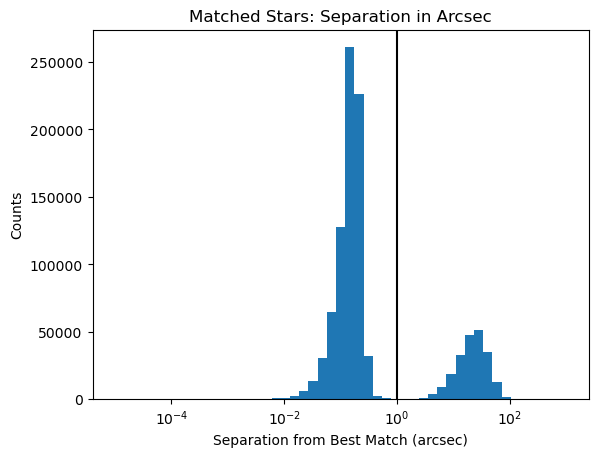

In [30]:
plt.hist(master_comb_df["sep2d"], bins = np.logspace(-5, 3))
plt.semilogx()
plt.axvline(1, color = "k")
plt.ylabel("Counts")
plt.xlabel("Separation from Best Match (arcsec)")
plt.title("Matched Stars: Separation in Arcsec")

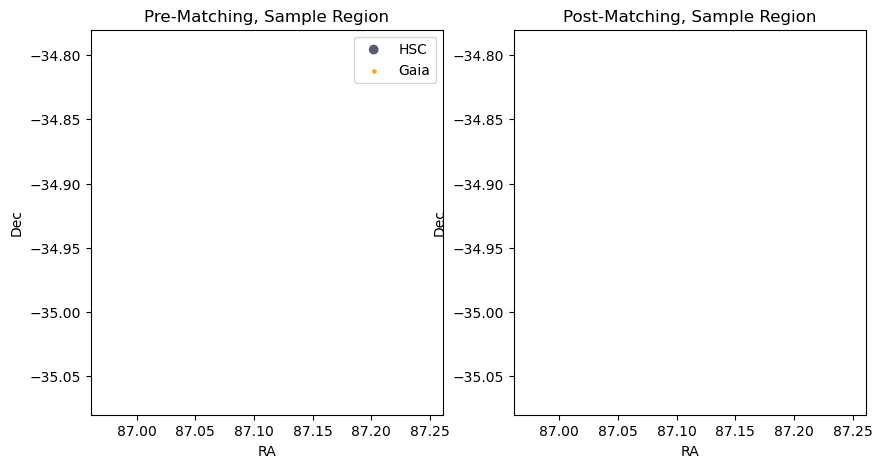

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))


# Scatter plot for the first subplot
ax[0].scatter(master_comb_df["cluster_ra"], master_comb_df["cluster_dec"], c = master_comb_df["mag0"], cmap = "cividis", 
              vmin = 18, vmax = 23, label = "HSC")
ax[0].scatter(master_comb_df["gaia_ra"], master_comb_df["gaia_dec"], s=5, color="orange", label = "Gaia")
ax[0].legend(loc = 'upper right')

# Set labels and limits for the first subplot
ax[0].set_xlabel("RA")
ax[0].set_ylabel("Dec")
ax[0].set_xlim(centroids[0][0] - 0.15, centroids[0][0] + 0.15)
ax[0].set_ylim(centroids[0][1] - 0.15, centroids[0][1] + 0.15)

ax[0].set_title("Pre-Matching, Sample Region")

# Scatter plot for the second subplot
match_idx = (master_comb_df["matched"] == 1)
ax[1].scatter(master_comb_df["cluster_ra"][match_idx], master_comb_df["cluster_dec"][match_idx], c = master_comb_df["mag0"][match_idx], cmap = "cividis",
              vmin = 18, vmax = 23)
ax[1].scatter(master_comb_df["gaia_ra"][match_idx], master_comb_df["gaia_dec"][match_idx], s=5, color="orange")

# Set labels and limits for the second subplot
ax[1].set_xlabel("RA")
ax[1].set_ylabel("Dec")
ax[1].set_xlim(centroids[0][0] - 0.15, centroids[0][0] + 0.15)
ax[1].set_ylim(centroids[0][1] - 0.15, centroids[0][1] + 0.15)

ax[1].set_title("Post-Matching, Sample Region")

# Show the plots
plt.show()

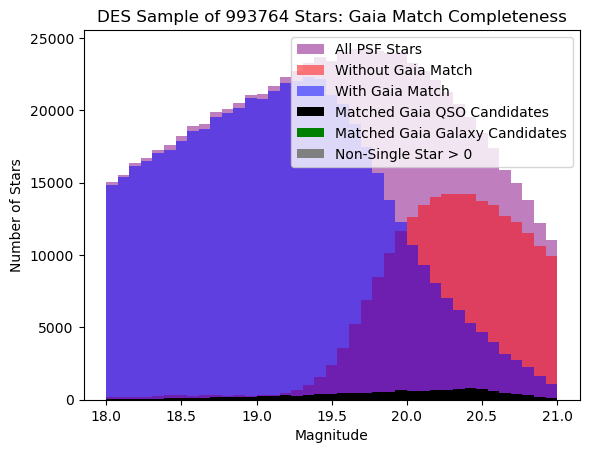

In [35]:
plt.hist(master_comb_df["mag0"], bins = np.linspace(18, 21, 40), label = "All PSF Stars", alpha = 0.5, color = "purple")
plt.hist(master_comb_df["mag0"][~match_idx], bins = np.linspace(18, 21, 40), label = "Without Gaia Match", alpha = 0.5, color = "red")
plt.hist(master_comb_df["mag0"][match_idx],bins = np.linspace(18, 21, 40), label = "With Gaia Match", alpha = 0.5, color = "blue")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_qso_candidates"] == True], bins = np.linspace(18, 21, 40), label = "Matched Gaia QSO Candidates", color = "black")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_galaxy_candidates"] == True], bins = np.linspace(18, 21, 40), label = "Matched Gaia Galaxy Candidates",color = "green")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["non_single_star"] > 0], bins = np.linspace(18, 21, 40), label = "Non-Single Star > 0",color = "grey")
plt.title(f"DES Sample of {len(master_comb_df)} Stars: Gaia Match Completeness")
plt.xlabel("Magnitude")
plt.ylabel("Number of Stars")
plt.legend()

In [6]:
# Save the dataframe to a csv file
master_comb_df.to_csv("../../psf_data/final_data/zdata/DESY3_Z_MATCHED.csv")

In [1]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia
import os

In [4]:
# Load all dataframes in folder and concatenate them
fold = "../../int_data/zdata/"
files = os.listdir(fold)
df_list = []
for file in files:
    df_list.append(pd.read_csv(fold + file, index_col=0))
    master_comb_df = pd.concat(df_list)

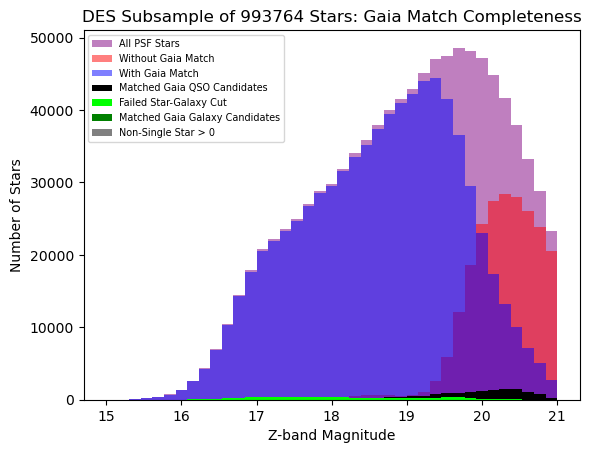

In [5]:
match_idx = (master_comb_df["matched"] == 1)
bounds = [15, 21]
super_match_idx = (master_comb_df[match_idx]["non_single_star"] == 0) & (master_comb_df[match_idx]["in_galaxy_candidates"] == False)
plt.hist(master_comb_df["mag0"], bins = np.linspace(bounds[0], bounds[1], 40), label = "All PSF Stars", alpha = 0.5, color = "purple")
plt.hist(master_comb_df["mag0"][~match_idx], bins = np.linspace(bounds[0], bounds[1], 40), label = "Without Gaia Match", alpha = 0.5, color = "red")
plt.hist(master_comb_df["mag0"][match_idx][super_match_idx],bins = np.linspace(bounds[0], bounds[1], 40), label = "With Gaia Match", alpha = 0.5, color = "blue")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_qso_candidates"] == True], bins = np.linspace(bounds[0], bounds[1], 40), label = "Matched Gaia QSO Candidates", color = "black")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["is_star"] == False], bins = np.linspace(bounds[0], bounds[1], 40), label = "Failed Star-Galaxy Cut", color = "lime")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_galaxy_candidates"] == True], bins = np.linspace(bounds[0], bounds[1], 40), label = "Matched Gaia Galaxy Candidates",color = "green")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["non_single_star"] > 0], bins = np.linspace(bounds[0], bounds[1], 40), label = "Non-Single Star > 0",color = "grey")
plt.title(f"DES Subsample of {len(master_comb_df)} Stars: Gaia Match Completeness")
plt.xlabel("Z-band Magnitude")
plt.ylabel("Number of Stars")
plt.legend(fontsize = "x-small")

In [13]:
import numpy as np

# Define the histogram parameters
bin_edges = np.linspace(14, 21, 40)
labels = ["All PSF Stars", "Without Gaia Match", "With Gaia Match", "Matched Gaia QSO Candidates",
          "Failed Star-Galaxy Cut", "Matched Gaia Galaxy Candidates", "Non-Single Star > 0"]
colors = ["purple", "red", "blue", "black", "lime", "green", "grey"]
conditions = [
    None,  # For "All PSF Stars"
    ~match_idx,  # For "Without Gaia Match"
    match_idx & super_match_idx,  # For "With Gaia Match"
    match_idx & master_comb_df[match_idx]["in_qso_candidates"] == True,  # For "Matched Gaia QSO Candidates"
    match_idx & master_comb_df[match_idx]["is_star"] == False,  # For "Failed Star-Galaxy Cut"
    match_idx & master_comb_df[match_idx]["in_galaxy_candidates"] == True,  # For "Matched Gaia Galaxy Candidates"
    match_idx & master_comb_df[match_idx]["non_single_star"] > 0  # For "Non-Single Star > 0"
]

# Create and display histograms using the parameters
plt.figure(figsize=(10, 6))
for label, color, condition in zip(labels, colors, conditions):
    if condition is not None:
        data = master_comb_df["mag0"][condition]
    else:
        data = master_comb_df["mag0"]
    plt.hist(data, bins=bin_edges, label=label, alpha=0.5, color=color)

plt.title(f"DES Subsample of {len(master_comb_df)} Stars: Gaia Match Completeness")
plt.xlabel("Z-band Magnitude")
plt.ylabel("Number of Stars")
plt.legend(fontsize="x-small")
plt.show()

KeyboardInterrupt: 

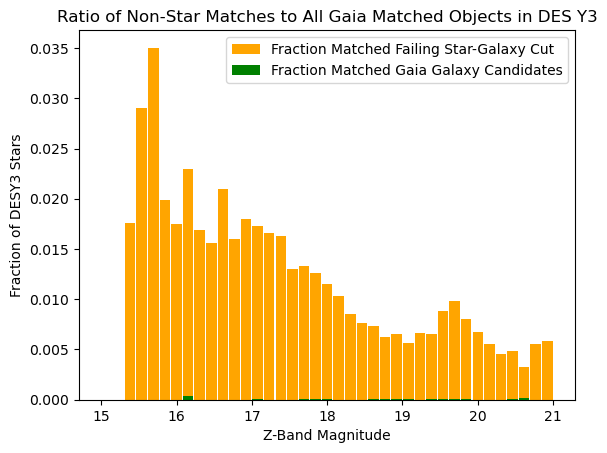

In [21]:
# Make a histogram using np.histogram

# Define the bins
bins = np.linspace(15, 21, 40)
all_match = np.histogram(master_comb_df["mag0"][match_idx], bins = bins)
galaxy_match = np.histogram(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_galaxy_candidates"] == True], bins = bins)
failed_star_galaxy_cut = np.histogram(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["is_star"] == False], bins = bins)

mid = lambda x: x[:-1] + np.diff(x)/2

plt.bar(mid(failed_star_galaxy_cut[1]), failed_star_galaxy_cut[0] / all_match[0], label = "Fraction Matched Failing Star-Galaxy Cut",color = "orange", width=0.14)
plt.bar(mid(galaxy_match[1]), galaxy_match[0] / all_match[0], label = "Fraction Matched Gaia Galaxy Candidates",color = "green", width=0.14)
plt.title("Ratio of Non-Star Matches to All Gaia Matched Objects in DES Y3")
plt.xlabel("Z-Band Magnitude")
plt.ylabel("Fraction of DESY3 Stars")
plt.legend()

Text(0, 0.5, 'Fraction of DESY3 Stars')

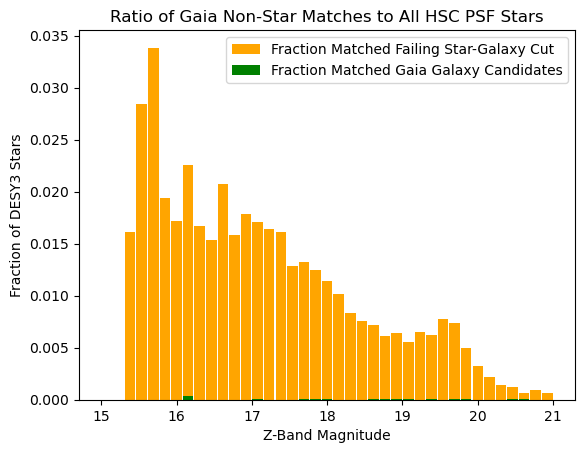

In [22]:
# Make a histogram using np.histogram

# Define the bins
bins = np.linspace(15, 21, 40)
all_match = np.histogram(master_comb_df["mag0"], bins = bins)
galaxy_match = np.histogram(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_galaxy_candidates"] == True], bins = bins)
failed_star_galaxy_cut = np.histogram(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["is_star"] == False], bins = bins)

mid = lambda x: x[:-1] + np.diff(x)/2

plt.bar(mid(failed_star_galaxy_cut[1]), failed_star_galaxy_cut[0] / all_match[0], label = "Fraction Matched Failing Star-Galaxy Cut",color = "orange", width=0.14)
plt.bar(mid(galaxy_match[1]), galaxy_match[0] / all_match[0], label = "Fraction Matched Gaia Galaxy Candidates",color = "green", width=0.14)
plt.title("Ratio of Gaia Non-Star Matches to All HSC PSF Stars")
plt.legend()
plt.xlabel("Z-Band Magnitude")
plt.ylabel("Fraction of DESY3 Stars")

In [38]:
(master_comb_df[match_idx]["in_galaxy_candidates"]).sum()

21

In [39]:
(master_comb_df[match_idx]["non_single_star"] > 0).sum()

6

In [40]:
(master_comb_df[match_idx]["in_qso_candidates"]).sum()

14135

In [41]:
(~master_comb_df[match_idx]["is_star"]).sum()

7416

In [6]:
comb_df = pd.read_csv("../int_data/DESY3_Cluster_1.csv")


(array([ 12.,  47., 120., 163., 220., 264., 308., 344., 314., 198.]),
 array([15.58727455, 16.12790508, 16.66853561, 17.20916615, 17.74979668,
        18.29042721, 18.83105774, 19.37168827, 19.9123188 , 20.45294933,
        20.99357986]),
 <BarContainer object of 10 artists>)

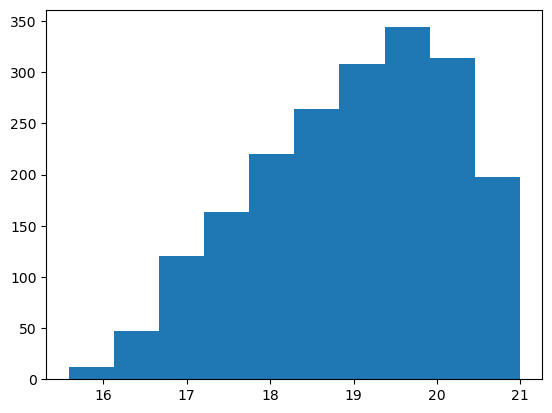

In [9]:
plt.hist(comb_df["mag0"])